In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np


In [10]:
import pandas as pd
scalar_vals_path = '../coefficient_comparison_results.csv'
results_df = pd.read_csv(scalar_vals_path)
print("\nResults from CSV:")
results_df.head()
# get min max of drag and lift coefficients percentage sample,remeshed_cd,clipped_cd,reference_cd,cd_diff_percent,remeshed_cl,clipped_cl,reference_cl,cl_diff_percent,remeshed_pressure_drag,clipped_pressure_drag,pressure_drag_diff_percent,remeshed_viscous_drag,clipped_viscous_drag,viscous_drag_diff_percent
def get_min_max_coefficients(results_df):
    """
    Get the minimum and maximum coefficients from the results DataFrame.
    
    Args:
        results_df (pd.DataFrame): DataFrame containing coefficient results.

    Returns:
        dict: Dictionary with min and max values for each coefficient.
    """ 
    coefficients = { 
        'cd_percent_diff': (results_df['cd_diff_percent'].min(), results_df['cd_diff_percent'].max()),
        'cl_percent_diff': (results_df['cl_diff_percent'].min(), results_df['cl_diff_percent'].max()), 
        'p_drag_diff_percent': (results_df['pressure_drag_diff_percent'].min(), results_df['pressure_drag_diff_percent'].max()),
        'nut_drag_diff_percent': (results_df['viscous_drag_diff_percent'].min(), results_df['viscous_drag_diff_percent'].max())
    }
    return coefficients

min_max_coeffs = get_min_max_coefficients(results_df)
print("\nMinimum and Maximum Coefficients:")

bin_values = { 'p': [], 'nut': [], 'ux': [], 'uy': []}

scalar_keys = ['cd', 'cl', 'pressure_drag', 'viscous_drag']
scalar_key_mapped_to_field = ['ux', 'uy', 'p', 'nut']

for key, value in min_max_coeffs.items():
    print(f"{key}: {value[0]:.6f}  {value[1]:.6f}")
    min_value, max_value = value
    # divide them into 3 bins
    low_bin = min_value + (max_value - min_value) / 3
    high_bin = min_value + 2 * (max_value - min_value) / 3
    if key == 'cd_percent_diff':
        bin_values['ux'] = (low_bin, high_bin)
    elif key == 'cl_percent_diff':
        bin_values['uy'] = (low_bin, high_bin)
    elif key == 'p_drag_diff_percent':
        bin_values['p'] = (low_bin, high_bin)
    elif key == 'nut_drag_diff_percent':
        bin_values['nut'] = (low_bin, high_bin)

print(f"\nBin Values: {len(bin_values)}") 
for key, value in bin_values.items():
    print(f"{key}: {value[0]:.6f}  {value[1]:.6f}")

def set_bin(field_type, index):
    low, high = bin_values[field_type]
    scalar_key = scalar_keys[scalar_key_mapped_to_field.index(field_type)]
    scalar_row = results_df.loc[index]
    if scalar_row[scalar_key + '_diff_percent'] is None:
        raise ValueError(f"Missing value for {scalar_key}_diff_percent at index {index}")
    value = scalar_row[scalar_key + '_diff_percent']
    if value < low:
        return 'low'
    elif value < high:
        return 'medium'
    else:
        return 'high'

# ux = cd_diff_percent, uy = cl_diff_percent, p = pressure_drag_diff_percent, nut = viscous_drag_diff_percent



Results from CSV:

Minimum and Maximum Coefficients:
cd_percent_diff: -23.202029  39.786285
cl_percent_diff: -300.309539  73.738826
p_drag_diff_percent: -481.123633  597.206932
nut_drag_diff_percent: -7.914196  1.381432

Bin Values: 4
p: -121.680111  237.763411
nut: -4.815653  -1.717111
ux: -2.205924  18.790180
uy: -175.626750  -50.943962


In [11]:
def load_data(data_frame: pd.DataFrame):
    """
    Loads images and their corresponding labels.
    """ 
    if os.path.exists(scalar_vals_path):
        scalar_vals_df = pd.read_csv(scalar_vals_path)
        scalar_vals_df.set_index('sample', inplace=True)
        print(f"Scalar values loaded from {scalar_vals_path}")
    else:
        raise FileNotFoundError(f"Scalar values file not found at {scalar_vals_path}")
    image_names = []
    images = []
    labels = [] 
    for index, row in data_frame.iterrows():
        for img_type in ['p', 'nut', 'ux', 'uy']:
            image_name = row[f'{img_type}_path']
            val_bin = set_bin(img_type, index)
            clipped_img_path = os.path.join('./raw_data_images', 'images', image_name)
            label = "_".join(image_name.split('_')[1:]).split('.')[0]  # Extract label from the filename
            if clipped_img_path and os.path.isfile(clipped_img_path):
                img = cv2.imread(clipped_img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224)).astype('float32') 
                    images.append(img)
                    # labels.append(row[f'{img_type}_label']) 
                    labels.append((img_type, 'clipped', val_bin))  # Store the type, clipped/remeshed, and bin value
                    image_names.append(image_name)
                else:
                    print(f"Warning: Unable to read image at {clipped_img_path}. Skipping this image.")

            # if 0_clipped_p.png and remeshed will be 0_remeshed_p.png replace with 0_clipped_p.png
            remeshed_img_path = clipped_img_path.replace('_clipped_', '_remeshed_')
            if remeshed_img_path and os.path.isfile(remeshed_img_path):
                remeshed_img = cv2.imread(remeshed_img_path)
                if remeshed_img is not None:
                    remeshed_img = cv2.resize(remeshed_img, (224, 224)).astype('float32')
                    images.append(remeshed_img)
                    # remeshed_labels.append(row[f'{img_type}_label']) 
                    # remeshed_label = label.replace('clipped_', 'remeshed_')
                    labels.append((img_type, 'remeshed', val_bin))
                    image_names.append(image_name.replace('_clipped_', '_remeshed_'))
                else:
                    print(f"Warning: Unable to read remeshed image at {remeshed_img_path}. Skipping this image.")
            else:
                print(f"Warning: Image path {clipped_img_path} does not exist or is not a file. Skipping this image.")

    return np.array(images), np.array(labels), image_names

#read the csv file meshdatasummery.csv as df
datadf = pd.read_csv('./raw_data_images/mesh_data_summary.csv')

images, labels, image_names = load_data(datadf)

Scalar values loaded from ../coefficient_comparison_results.csv


In [12]:
print(f"Loaded {len(images)} images with labels.")

Loaded 8000 images with labels.


In [13]:
labels = np.array(labels)
print(np.unique(labels[:, 0]), np.unique(labels[:, 1]), np.unique(labels[:, 2])) 

['nut' 'p' 'ux' 'uy'] ['clipped' 'remeshed'] ['high' 'low' 'medium']


In [14]:
# Custom Train-Validation-Test Split
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 

# Preprocess images for VGG16
images_preprocessed = preprocess_input(images.copy())

# 1. Split the labels into their components
fields = np.unique(labels[:, 0])     # e.g., ['p', 'nut', 'ux', 'uy']
processes = np.unique(labels[:, 1])  # e.g., ['remeshed', 'clipped']
intensities = np.unique(labels[:, 2]) # e.g., ['low', 'high', 'medium']

# 2. Create and fit a separate encoder for each task
field_encoder = LabelEncoder()
process_encoder = LabelEncoder()
intensity_encoder = LabelEncoder()

# Fit encoders on all possible unique values for each task
field_encoder.fit(fields)
process_encoder.fit(processes)
intensity_encoder.fit(intensities)

# 3. Transform the original labels for each task
y_field_int = field_encoder.transform(labels[:, 0])
y_process_int = process_encoder.transform(labels[:, 1])
y_intensity_int = intensity_encoder.transform(labels[:, 2])

# 4. One-hot encode each integer list
y_field = to_categorical(y_field_int, num_classes=len(fields))
y_process = to_categorical(y_process_int, num_classes=len(processes))
y_intensity = to_categorical(y_intensity_int, num_classes=len(intensities))
 
print("Field Labels Shape:", y_field.shape)
print("Process Labels Shape:", y_process.shape)
print("Intensity Labels Shape:", y_intensity.shape)

# Create indices for stratified splitting
indices = np.arange(len(images))

# Stratify based on the 'field' label, which is less likely to have unique instances
stratify_labels = y_field_int

# First split: separate test set (20% of total data)
train_val_indices, test_indices = train_test_split(
    indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels
)

# Second split: divide remaining data into train (64%) and validation (16%)
train_indices, val_indices = train_test_split(
    train_val_indices, 
    test_size=0.2,  # 20% of the remaining 80% = 16% of total
    random_state=42, 
    stratify=stratify_labels[train_val_indices]
)

# Split the input images
X_train = images_preprocessed[train_indices]
X_val = images_preprocessed[val_indices]
X_test = images_preprocessed[test_indices]

# CRITICAL: Split each of the three one-hot encoded label sets
y_field_train, y_field_val, y_field_test = y_field[train_indices], y_field[val_indices], y_field[test_indices]
y_process_train, y_process_val, y_process_test = y_process[train_indices], y_process[val_indices], y_process[test_indices]
y_intensity_train, y_intensity_val, y_intensity_test = y_intensity[train_indices], y_intensity[val_indices], y_intensity[test_indices]

# You can now prepare the label dictionaries for model.fit()
y_train_dict = {
    'field_output': y_field_train,
    'process_output': y_process_train,
    'intensity_output': y_intensity_train
}
y_val_dict = {
    'field_output': y_field_val,
    'process_output': y_process_val,
    'intensity_output': y_intensity_val
}
y_test_dict = {
    'field_output': y_field_test,
    'process_output': y_process_test,
    'intensity_output': y_intensity_test
}

# Create test set CSV
test_df = pd.DataFrame({
    'image_name': [image_names[i] for i in test_indices],
    'label': ["_".join(l) for l in labels[test_indices]],
    'field_label': field_encoder.inverse_transform(y_field_test.argmax(axis=1)),
    'process_label': process_encoder.inverse_transform(y_process_test.argmax(axis=1)),
    'intensity_label': intensity_encoder.inverse_transform(y_intensity_test.argmax(axis=1))
})

# Save test set to CSV
test_csv_path = './test_set_with_new_labels.csv'
test_df.to_csv(test_csv_path, index=False)

print(f"\nData split completed:")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(images)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(images)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(images)*100:.1f}%)")
print(f"Test set saved to: {test_csv_path}")

# Verify class distribution in each split
print(f"\nClass distribution in training set (field): {np.bincount(y_field_train.argmax(axis=1))}")
print(f"Class distribution in validation set (field): {np.bincount(y_field_val.argmax(axis=1))}")
print(f"Class distribution in test set (field): {np.bincount(y_field_test.argmax(axis=1))}")

# Display first few entries of test set
print(f"\nFirst 5 entries of test set:")
print(test_df.head())

Field Labels Shape: (8000, 4)
Process Labels Shape: (8000, 2)
Intensity Labels Shape: (8000, 3)

Data split completed:
Training set size: 5120 (64.0%)
Validation set size: 1280 (16.0%)
Test set size: 1600 (20.0%)
Test set saved to: ./test_set_with_new_labels.csv

Class distribution in training set (field): [1280 1280 1280 1280]
Class distribution in validation set (field): [320 320 320 320]
Class distribution in test set (field): [400 400 400 400]

First 5 entries of test set:
             image_name              label field_label process_label  \
0    105_clipped_Uy.png    uy_clipped_high          uy       clipped   
1     64_clipped_Ux.png  ux_clipped_medium          ux       clipped   
2    583_remeshed_p.png  p_remeshed_medium           p      remeshed   
3    471_remeshed_p.png  p_remeshed_medium           p      remeshed   
4  763_remeshed_nut.png  nut_remeshed_high         nut      remeshed   

  intensity_label  
0            high  
1          medium  
2          medium  
3    

In [ ]:
# Model Setup and Training
# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
# x = Dense(512, activation='relu')(x)

# --- 2. Three Classifier Heads ---
# Head for the 'field' task (4 classes)
field_head = Dense(4, activation='softmax', name='field_output')(x)

# Head for the 'process' task (2 classes)
process_head = Dense(2, activation='softmax', name='process_output')(x)

# Head for the 'intensity' task (3 classes)
intensity_head = Dense(3, activation='softmax', name='intensity_output')(x)

# predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=[field_head, process_head, intensity_head])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss={
                  'field_output': 'categorical_crossentropy',
                  'process_output': 'categorical_crossentropy',
                  'intensity_output': 'categorical_crossentropy'
              }, 
              metrics=['accuracy'])

# Display model summary
print("Model architecture:")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Total trainable parameters: {model.count_params()}")

# Train the model and capture history
print("\nStarting training...")
history_10 = model.fit(X_train, y_train_dict, validation_data=(X_val, y_val_dict), epochs=10, batch_size=8, verbose=1)

Model architecture:
Input shape: (None, 224, 224, 3)
Output shape: [(None, 4), (None, 2), (None, 3)]
Total trainable parameters: 14940489

Starting training...
Epoch 1/10
Epoch 1/10


2025-07-20 17:13:00.507160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


640/640 [==============================] - ETA: 0s - loss: 1.9663 - field_output_loss: 0.0640 - process_output_loss: 1.1695 - intensity_output_loss: 0.7328 - field_output_accuracy: 0.9859 - process_output_accuracy: 0.5738 - intensity_output_accuracy: 0.8150

2025-07-20 17:14:17.385304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


640/640 [==============================] - 96s 149ms/step - loss: 1.9663 - field_output_loss: 0.0640 - process_output_loss: 1.1695 - intensity_output_loss: 0.7328 - field_output_accuracy: 0.9859 - process_output_accuracy: 0.5738 - intensity_output_accuracy: 0.8150 - val_loss: 1.7540 - val_field_output_loss: 0.0013 - val_process_output_loss: 0.9198 - val_intensity_output_loss: 0.8329 - val_field_output_accuracy: 1.0000 - val_process_output_accuracy: 0.6086 - val_intensity_output_accuracy: 0.8055
Epoch 2/10
Epoch 2/10
640/640 [==============================] - 94s 147ms/step - loss: 1.3844 - field_output_loss: 0.0013 - process_output_loss: 0.8099 - intensity_output_loss: 0.5731 - field_output_accuracy: 0.9998 - process_output_accuracy: 0.6482 - intensity_output_accuracy: 0.8373 - val_loss: 1.7357 - val_field_output_loss: 0.0047 - val_process_output_loss: 0.7759 - val_intensity_output_loss: 0.9552 - val_field_output_accuracy: 0.9992 - val_process_output_accuracy: 0.6539 - val_intensity_ou

In [ ]:
# continue with 50 epochs and save the model
history_50 = model.fit(X_train, y_train_dict, validation_data=(X_val, y_val_dict), epochs=40, batch_size=8, verbose=1)

Epoch 1/40
640/640 [==============================] - 99s 154ms/step - loss: 0.8327 - field_output_loss: 2.1246e-05 - process_output_loss: 0.4736 - intensity_output_loss: 0.3591 - field_output_accuracy: 1.0000 - process_output_accuracy: 0.7957 - intensity_output_accuracy: 0.8869 - val_loss: 1.2776 - val_field_output_loss: 2.2497e-05 - val_process_output_loss: 0.6551 - val_intensity_output_loss: 0.6224 - val_field_output_accuracy: 1.0000 - val_process_output_accuracy: 0.7445 - val_intensity_output_accuracy: 0.8219
Epoch 2/40
640/640 [==============================] - 99s 154ms/step - loss: 0.8327 - field_output_loss: 2.1246e-05 - process_output_loss: 0.4736 - intensity_output_loss: 0.3591 - field_output_accuracy: 1.0000 - process_output_accuracy: 0.7957 - intensity_output_accuracy: 0.8869 - val_loss: 1.2776 - val_field_output_loss: 2.2497e-05 - val_process_output_loss: 0.6551 - val_intensity_output_loss: 0.6224 - val_field_output_accuracy: 1.0000 - val_process_output_accuracy: 0.7445 - 

KeyboardInterrupt: 

In [ ]:

# Save the trained model
model.save('vgg16_finetuned_3_encoders.h5')

print("Model training complete and saved as vgg16_finetuned_3_encoders.h5")

/Users/saikirannunemunthala/Files/Lectures/Thesis/AirfranceDatasetAnalysis/.conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model training complete and saved as vgg16_finetuned_remeshed.h5


In [ ]:
# combile the history of all three training runs
history_combined = {}
for key in history_10.history.keys():
    history_combined[key] = history_10.history[key] + history_50.history[key]


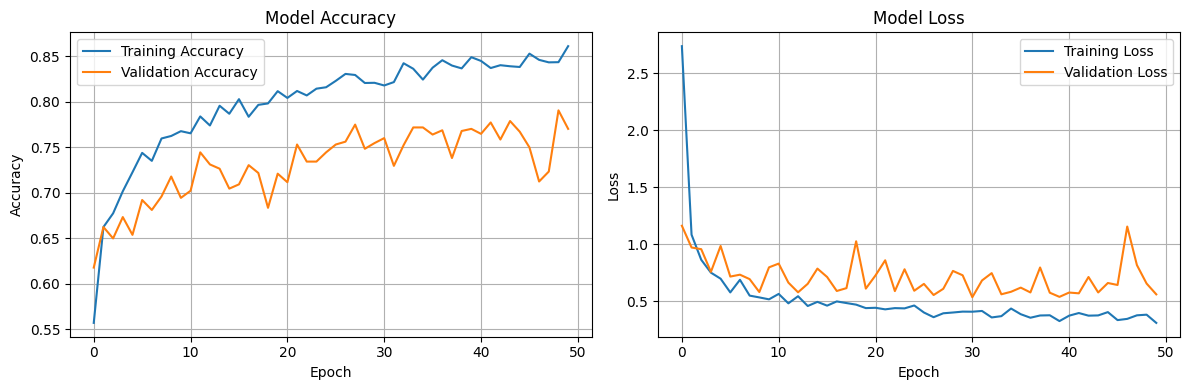

Final Training Accuracy: 0.8611
Final Validation Accuracy: 0.7703
Final Training Loss: 0.3097
Final Validation Loss: 0.5601


In [ ]:
# Plot training history
plt.figure(figsize=(15, 10))

# Plot accuracies
plt.subplot(2, 2, 1)
plt.plot(history_combined['field_output_accuracy'], label='Field Training Accuracy')
plt.plot(history_combined['val_field_output_accuracy'], label='Field Validation Accuracy')
plt.title('Field Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_combined['process_output_accuracy'], label='Process Training Accuracy')
plt.plot(history_combined['val_process_output_accuracy'], label='Process Validation Accuracy')
plt.title('Process Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history_combined['intensity_output_accuracy'], label='Intensity Training Accuracy')
plt.plot(history_combined['val_intensity_output_accuracy'], label='Intensity Validation Accuracy')
plt.title('Intensity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot total loss
plt.subplot(2, 2, 4)
plt.plot(history_combined['loss'], label='Training Loss')
plt.plot(history_combined['val_loss'], label='Validation Loss')
plt.title('Total Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history_combined['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_combined['val_loss'][-1]:.4f}")
print("\n--- Final Accuracies ---")
print(f"Field: Train={history_combined['field_output_accuracy'][-1]:.4f}, Val={history_combined['val_field_output_accuracy'][-1]:.4f}")
print(f"Process: Train={history_combined['process_output_accuracy'][-1]:.4f}, Val={history_combined['val_process_output_accuracy'][-1]:.4f}")
print(f"Intensity: Train={history_combined['intensity_output_accuracy'][-1]:.4f}, Val={history_combined['val_intensity_output_accuracy'][-1]:.4f}")
